In [2]:
import pandas as pd 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np

## Reading in the Data 

In [3]:
pwd = os.getcwd()
filepath = os.path.join(pwd, 'drug200.csv')

In [4]:
drug_data = pd.read_csv(filepath)
drug_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


## Exploring the Data

In [5]:
drug_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [6]:
### Are there any null values? ###
drug_data.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

## Visualizing the Data

In [7]:
drug = drug_data.copy()

<AxesSubplot:xlabel='Drug', ylabel='count'>

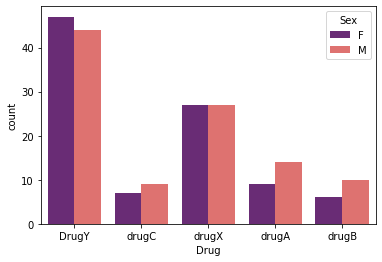

In [8]:
sns.countplot(x = 'Drug', data = drug, palette="magma", hue='Sex')

#### DrugY has the most frequency, which means it will be the highest predicted drug in our model.
#### No relationship between sex and drug use.

<AxesSubplot:xlabel='BP', ylabel='count'>

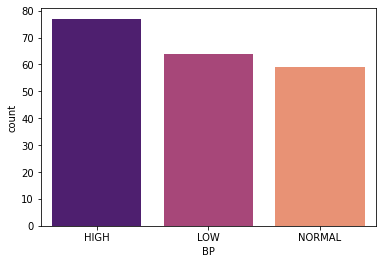

In [9]:
sns.countplot(x = 'BP', data = drug, palette="magma")

<AxesSubplot:xlabel='Cholesterol', ylabel='count'>

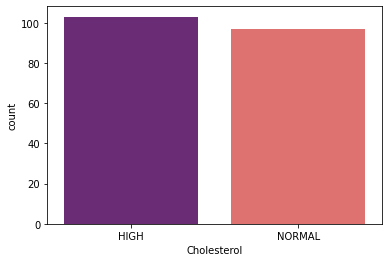

In [10]:
sns.countplot(x = 'Cholesterol', data = drug, palette="magma")

<AxesSubplot:>

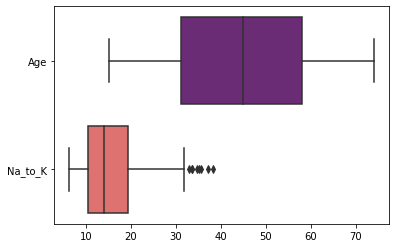

In [11]:
sns.boxplot(data=drug, palette="magma", orient="h")

#### We can see that there are a few outliers in the Na_to_K column

In [12]:
### Removing the outliers using IQR ###
IQR1= np.quantile(drug['Na_to_K'],0.25)
IQR3= np.quantile(drug['Na_to_K'],0.75)
IQR=IQR3-IQR1
IQR

8.934499999999998

In [13]:
outliers = drug[drug['Na_to_K'] > (IQR3+1.5*IQR)]
outliers

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
24,33,F,LOW,HIGH,33.486,DrugY
96,58,F,LOW,HIGH,38.247,DrugY
98,20,M,HIGH,NORMAL,35.639,DrugY
128,47,M,LOW,NORMAL,33.542,DrugY
131,52,M,LOW,NORMAL,32.922,DrugY
184,18,F,HIGH,HIGH,37.188,DrugY
188,65,M,HIGH,NORMAL,34.997,DrugY
194,46,F,HIGH,HIGH,34.686,DrugY


In [14]:
drug.drop(outliers.index.tolist(),axis=0,inplace=True)

<AxesSubplot:xlabel='Na_to_K'>

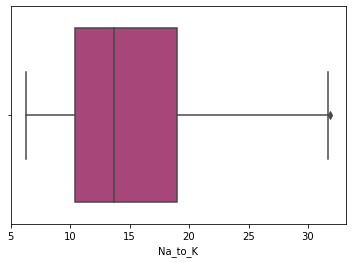

In [15]:
sns.boxplot(x = 'Na_to_K', data=drug, palette="magma", orient="h")

#### Outliers have been removed

## Feature Engineering 

### Encoding categorical variables

In [16]:
{column: len(drug[column].unique()) for column in drug.columns}

{'Age': 56, 'Sex': 2, 'BP': 3, 'Cholesterol': 2, 'Na_to_K': 190, 'Drug': 5}

In [17]:
### Using binary encoding on sex and cholesterol columms because both of them consist of only 2 variables ###
def binary_encode(data, col, value):
    drugc = drug.copy()
    drugc[col] = drugc[col].apply(lambda x: 1 if x == value else 0)
    return drugc

In [18]:
drug = binary_encode(drug, 'Sex', 'M')
drug = binary_encode(drug, 'Cholesterol', 'HIGH')

In [19]:
### The categorical features are ordinal in this dataset, so I decided to use label encoding on columns with more than 2 variables 
from sklearn import preprocessing 
label_e = preprocessing.LabelEncoder() 
drug['BP'] = label_e.fit_transform(drug['BP'])

#### Now our dataset have all numeric values, and we can start our model building 

In [20]:
scaled_data = drug.copy()
scaled_data.head(10)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,1,25.355,DrugY
1,47,1,1,1,13.093,drugC
2,47,1,1,1,10.114,drugC
3,28,0,2,1,7.798,drugX
4,61,0,1,1,18.043,DrugY
5,22,0,2,1,8.607,drugX
6,49,0,2,1,16.275,DrugY
7,41,1,1,1,11.037,drugC
8,60,1,2,1,15.171,DrugY
9,43,1,1,0,19.368,DrugY


## Building and Testing the Model

In [21]:
X = scaled_data.drop('Drug', axis = 1)
y = scaled_data.Drug

#### Dataset splitted into training and testing 

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X_train

,Age,Sex,BP,Cholesterol,Na_to_K
149,22,1,1,1,8.151
39,15,1,2,1,9.084
48,23,1,2,1,31.686
69,18,0,0,0,24.276
125,19,0,0,0,25.969
...,...,...,...,...,...
104,22,1,0,0,28.294
66,29,1,0,1,12.856
52,62,1,1,0,27.183
33,65,0,0,0,31.876


In [23]:
###Function to print accuracy, precision, and recall score of differnet models###
def algo_accuracy(ytest, pred):
    acc = accuracy_score(ytest, pred)
    prec = precision_score(ytest, pred, average='macro')
    rec = recall_score(ytest, pred, average='macro')

    return print('Accuracy score: ', acc*100,
        '\nPrecision score: ', prec*100,
        '\nRecall score: ', rec*100)

In [24]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
knc = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knc, X, y, cv=6, scoring = 'accuracy')
knc.fit(X_train, y_train)
y_knn_pred = knc.predict(X_test)

print("Kneighbor Classifier: ")
algo_accuracy(y_test, y_knn_pred)
print("Cross-Validation accuracy score: ", np.mean(scores)*100)

Kneighbor Classifier: 
Accuracy score:  64.1025641025641 
Precision score:  47.333333333333336 
Recall score:  47.33333333333333
Cross-Validation accuracy score:  71.35416666666666


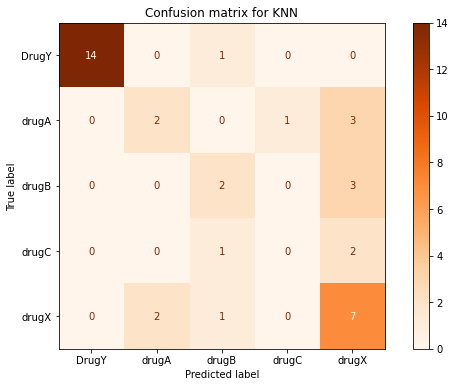

In [36]:
from sklearn.metrics import plot_confusion_matrix
matrix = plot_confusion_matrix(knc, X_test, y_test, cmap=plt.cm.Oranges)
matrix.ax_.set_title("Confusion matrix for KNN", color='black')
plt.xlabel('Predicted label', color = 'black')
plt.ylabel('True label', color = 'black')
plt.gcf().axes[0].tick_params(colors='black')
plt.gcf().axes[1].tick_params(colors='black')
plt.gcf().set_size_inches(10,6)
plt.show()

In [26]:
from sklearn import linear_model
log_reg = linear_model.LogisticRegression(max_iter = 5000)
scores = cross_val_score(log_reg, X, y, cv=6, scoring = 'accuracy')
log_reg.fit(X_train, y_train)
y_log_pred = log_reg.predict(X_test)

print("Logistic Regression:")
algo_accuracy(y_test, y_log_pred)
print("Cross-Validation accuracy score: ", np.mean(scores)*100)

Logistic Regression:
Accuracy score:  92.3076923076923 
Precision score:  93.75 
Recall score:  85.33333333333333
Cross-Validation accuracy score:  95.83333333333334


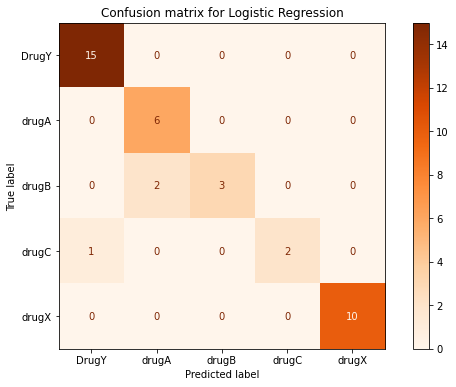

In [35]:
matrix = plot_confusion_matrix(log_reg, X_test, y_test, cmap=plt.cm.Oranges)
matrix.ax_.set_title("Confusion matrix for Logistic Regression", color='black')
plt.xlabel('Predicted label', color = 'black')
plt.ylabel('True label', color = 'black')
plt.gcf().axes[0].tick_params(colors='black')
plt.gcf().axes[1].tick_params(colors='black')
plt.gcf().set_size_inches(10,6)
plt.show()

In [28]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = 42)
scores = cross_val_score(log_reg, X, y, cv=6, scoring = 'accuracy')
rfc.fit(X_train,y_train)
y_rfc_pred = rfc.predict(X_test)

print("Random Forest Classifier:")
algo_accuracy(y_test, y_rfc_pred)
print("Cross-Validation accuracy score: ", np.mean(scores)*100)

Random Forest Classifier:
Accuracy score:  94.87179487179486 
Precision score:  95.0 
Recall score:  92.0
Cross-Validation accuracy score:  95.83333333333334


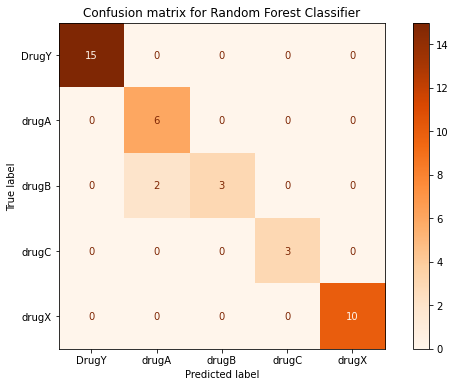

In [31]:
matrix = plot_confusion_matrix(rfc, X_test, y_test, cmap=plt.cm.Oranges)
matrix.ax_.set_title("Confusion matrix for Random Forest Classifier", color='black')
plt.xlabel('Predicted label', color = 'black')
plt.ylabel('True label', color = 'black')
plt.gcf().axes[0].tick_params(colors='black')
plt.gcf().axes[1].tick_params(colors='black')
plt.gcf().set_size_inches(10,6)
plt.show()

# Summary: 

### Random Forest Classifier and Logistic Regression have the best scores. Knn turned out to be the worst model. 